Execution for house price estimation

In [1]:
# Import relevant files and libraries
import DataProcessor
import sys
import LRegression
import NLRegression
import performance_metrics
import Kmeans
import UserInterface
import numpy as np

Define the parameters



In [2]:
# Allocate 80% of data to training
train_size = 0.8

# Identify features to be used
columnsToKeep = ['Price','Type','Bedroom','Bathroom','Car','Landsize','BuildingArea','Latitude','Longitude']
#columnsToKeep = ['Price', 'Bedroom', 'Bathroom']
#columnsToKeep = ['Price', 'Type', 'Landsize', 'BuildingArea']

# Path to dataset.
filepath = '../dataset/Melbourne_housing_FULL.csv'

# Identify prediction (ground truth)
prediction_column = 'Price'

Process raw data

Data Processor object created
Number of rows removed: 1935
Number of rows remaining: 7438


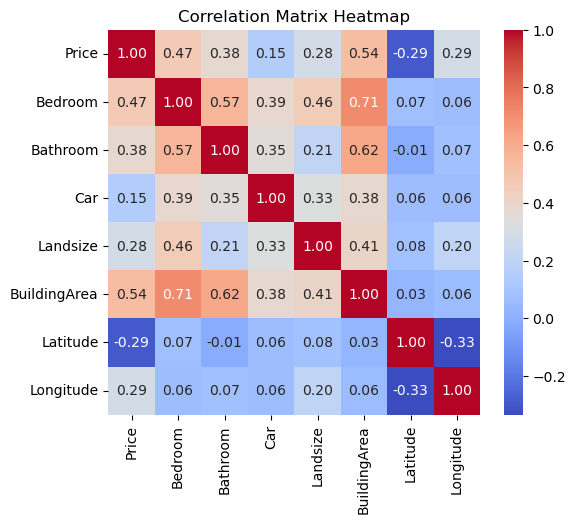

training size 800
test size 200


In [3]:
# Create a DataProcessor object and load the data
dp_obj = DataProcessor.DataProcessor()
dp_obj.LoadData(filepath)

# Remove incomplete points, remove unused features and shuffle the data
dp_obj.keepSelectedColumns(columnsToKeep)
dp_obj.filterMelbourneData()

dp_obj.remove_outliers(columnsToKeep, plot=False)

# dp_obj.encodeCategoricalData(['Type'])
dp_obj.shuffleData()
dp_obj.reduceDataSize(1000) # remove this to train on the full dataset


columnsToCorrelate = ['Price','Bedroom','Bathroom','Car','Landsize','BuildingArea','Latitude','Longitude']
dp_obj.calculateCorelation(columnsToCorrelate)

# Split the data into training and testing
train_X, train_Y, test_X, test_Y = dp_obj.splitData(train_size, prediction_column)

# print(train_X.head())

# Remove dwelling type and additional landsize / building area data for some processing
clean_columns = ['Type', 'Landsize','BuildingArea']
train_X_clean = train_X.drop(columns=clean_columns,axis=1)
test_X_clean = test_X.drop(columns=clean_columns,axis=1)

K-Means Clustering

In [4]:
# Ashton
k = 3
# prefs = ['Type','Bedroom','Bathroom','Car','Landsize','BuildingArea','Latitude','Longitude']
prefs = ['Type','Bedroom','Bathroom','Car','Landsize','BuildingArea','Latitude','Longitude']

all_points = []
all_centroids = []

for pref in prefs:
    kmeansTrain = Kmeans.Kmeans(train_X, train_Y, k, pref)

    train_X, points, centroids = kmeansTrain.cluster()

    all_points.append(points)
    all_centroids.append(centroids)
    
    # Plot the data
    # kmeansTrain.plotKmean(train_X, points, centroids, pref)

for pref in prefs:
    kmeansTest = Kmeans.Kmeans(test_X, test_Y, k, pref)

    test_X, points, centroids = kmeansTest.cluster()

    all_points.append(points)
    all_centroids.append(centroids)

    # Plot the data
    # kmeansTest.plotKmean(test_X, points, centroids, pref)

# kmeans = Kmeans.Kmeans(train_X, train_Y, k, prefs)

# train_X, points, centroids = kmeans.cluster()

# all_points.append(points)
# all_centroids.append(centroids)

# kmeans.plotKmean(train_X, points, centroids, prefs)

print('train_X columns')
print(train_X.columns)

print('test_X columns')
print(test_X.columns)

train_X columns
Index(['Type', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'Latitude', 'Longitude', 'Size', 'AssignmentType', 'AssignmentBedroom',
       'AssignmentBathroom', 'AssignmentCar', 'AssignmentLandsize',
       'AssignmentBuildingArea', 'AssignmentLatitude', 'AssignmentLongitude'],
      dtype='object')
test_X columns
Index(['Type', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'Latitude', 'Longitude', 'Size', 'AssignmentType', 'AssignmentBedroom',
       'AssignmentBathroom', 'AssignmentCar', 'AssignmentLandsize',
       'AssignmentBuildingArea', 'AssignmentLatitude', 'AssignmentLongitude'],
      dtype='object')


Linear Regression

In [ ]:
# Train
# @TODO: Update for building type
lr = LRegression.LRegression()
values = ['Bedroom','Bathroom','Car','Landsize','BuildingArea','Latitude','Longitude']
assignments = ['AssignmentBedroom','AssignmentBathroom','AssignmentCar','AssignmentLandsize','AssignmentBuildingArea','AssignmentLatitude','AssignmentLongitude']
w = []
train_mse = []
for i in range(k):
    weight = lr.LinReg(train_X,train_Y,values,assignments,i)
    w.append(weight)
w = np.array(w)
w = w.reshape(w.shape[0],w.shape[1],-1)
for i in range(k):
    train_mse.append(lr.MSE(train_X[values],w[i,:],train_Y))

print("Training error = ", train_mse)

In [ ]:
# Test
# @TODO: Update for building type
lr = LRegression.LRegression()
values = ['Bedroom','Bathroom','Car','Landsize','BuildingArea','Latitude','Longitude']
assignments = ['AssignmentBedroom','AssignmentBathroom','AssignmentCar','AssignmentLandsize','AssignmentBuildingArea','AssignmentLatitude','AssignmentLongitude']
test_mse = []
for i in range(k):
    test_mse.append(lr.MSE(test_X[values],w[i,:],test_Y))

print("Testing error = ", test_mse)

Non-Linear Regression (Gaussian Processing)

In [5]:
# Train

# ['Type', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
#        'Latitude', 'Longitude', 'Size', 'AssignmentType', 'AssignmentBedroom',
#        'AssignmentBathroom', 'AssignmentCar', 'AssignmentLandsize',
#        'AssignmentBuildingArea', 'AssignmentLatitude', 'AssignmentLongitude']

# ['Size','Latitude','Longitude']

featuresToTrain = ['Size','Latitude','Longitude', 'Bedroom', 'Bathroom', 'AssignmentLatitude', 'AssignmentLongitude'] # ['Size','Latitude', 'AssignmentLatitude' ,'Longitude', 'AssignmentLongitude']

# ask to train or load a model
query = input("Do you want to train a new model? (y/n): ")
if query == 'y':
    # Ask user for features to train on
    nlr = NLRegression.NLRegression(train_X, train_Y, test_X, test_Y, featuresToTrain)
    nlr.train()
    # ask to save
    query = input("Do you want to save the model? (y/n): ")
    if query == 'y':
        filepath_ = '../saved_models/nlr_model_R_2_' + str(nlr.evaluate())
        nlr.saveModel(filepath_)
else:
    nlr = NLRegression.NLRegression(train_X, train_Y, test_X, test_Y, featuresToTrain)
    filename_ = input("Enter the filename of the model to load: ")
    nlr.loadModel(filename_)

# options: 'Type','Bedroom','Bathroom','Car','Size','Latitude','Longitude'


/opt/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


R² Score: 0.8843400837292649


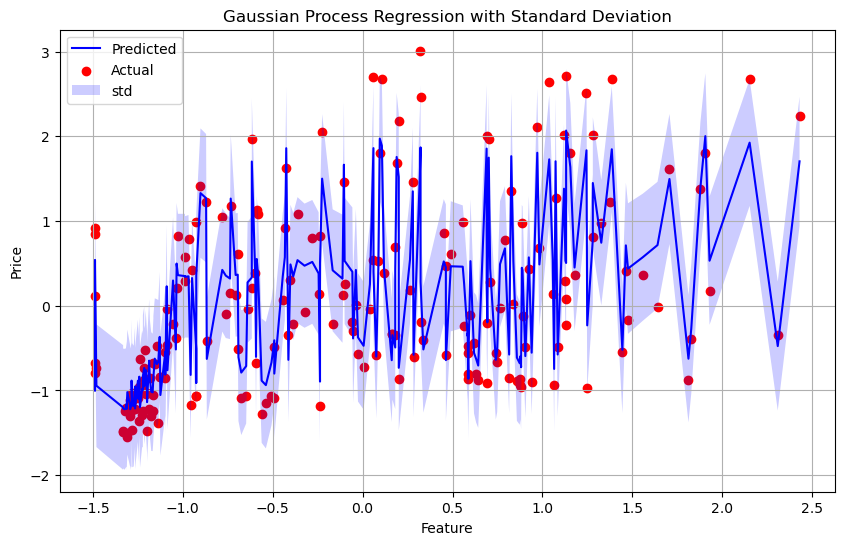

In [6]:
# plotting predictions vs expected
nlr.plot()

In [7]:
# slow but more accurate test
nlr.cross_validate()

/opt/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Cross-Validation Scores (R²): [0.88942705 0.81742191 0.88192828]
Mean R²: 0.8629257499719515, Standard Deviation: 0.032321378262061454


/opt/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/ai/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [9]:
# Select a sample row and keep it as a Series
sample_number = 10

sample = test_X[featuresToTrain].iloc[sample_number]
print("sample: ", sample.values)

# Predict using the model with the scaled data
pred, bounds = nlr.predictActual(sample)
print("prediction: ", pred[0])
# print("bounds:     ", bounds[0], bounds[1])
print("actual:     ", test_Y.iloc[sample_number])

sample:  [427.     -37.8367 145.0934   2.       1.       1.       1.    ]
prediction:  1179879.3484336713
actual:      1302000.0


Evaluation Metrics

In [ ]:
from performance_metrics import ElbowMethod
from DataProcessor import DataProcessor
import pandas as pd
from sklearn.impute import SimpleImputer

# Identify features to be used (excluding 'Type')
columnsToKeep = ['Price', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Latitude', 'Longitude']

# Path to dataset
filepath = '../dataset/Melbourne_housing_FULL.csv'

# Step 1: Load and preprocess the data
data_processor = DataProcessor()
data = data_processor.LoadData(filepath)

# Drop columns that are not relevant or cannot be converted to numeric
data = data_processor.keepSelectedColumns(columnsToKeep)

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Step 2: Use the ElbowMethod class with the preprocessed data
elbow_method = ElbowMethod(data)  # Initialize ElbowMethod
elbow_method.evaluate(max_clusters=10)
elbow_method.plot()
optimal_clusters = elbow_method.optimal_number_of_clusters()
print("Optimal number of clusters:", optimal_clusters)


In [ ]:
from performance_metrics import calculate_silhouette_score
# Assuming kmeans.cluster() returns x_new, points, centroids
x_new, points, centroids = kmeans.cluster()
assignment = x_new['Assignment' + pref].values  # Extract the cluster assignments

silhouette_avg = calculate_silhouette_score(points, assignment)
print("Silhouette Score:", silhouette_avg)

User input for preference

In [ ]:
# Calculate mean values if no user preference is provided
meanLand = dp_obj.getAverage('Landsize')
meanBuilding = dp_obj.getAverage('BuildingArea')

# Input user preferences
user_pref = UserInterface.UserInterface()
type, bedrooms, bathrooms, car, size, latitude, longitude = user_pref.Inputs(meanLand, meanBuilding)
print(type,bedrooms,bathrooms,car,size,latitude,longitude)

Final prediction

In [10]:
# Return predicted value from best performing model
# @TODO: Update for building type
# @TODO: Update for 'luxury' level (cluster number)
# targets = [type,bedrooms,bathrooms,car,size,latitude,longitude]
targets = [3,2,1,1000,100,-37.5903,145.2507]
pred = lr.predict(targets,w[0,:])

NameError: name 'lr' is not defined